# Naive Portfolio Optimization

This notebook demonstrates a baseline portfolio optimization strategy using naive mean-variance optimization. We work with historical weekly data for a set of assets (ticker symbols) and go through the following steps:

1. **Data Loading and Returns Calculation:**  
   - Load cleaned historical price data.
   - Compute weekly returns.

2. **Statistical Calculations:**  
   - Compute mean returns and the covariance matrix of returns.

3. **Portfolio Optimization:**  
   - Construct the efficient frontier by varying risk premiums.
   - Identify the optimal portfolio that maximizes the Sharpe ratio.

4. **Visualization:**  
   - Plot the efficient frontier.
   - Visualize cumulative returns interactively.

5. **Performance Evaluation:**  
   - Compute key metrics: annualized return, annualized risk, and Sharpe ratio.

In [ ]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.optimize import minimize

# visual style for plots

sns.set(style="whitegrid", context="talk", palette="deep")

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
from google.colab import files

# Upload your cleaned CSV file (historical_prices_cleaned.csv)
uploaded = files.upload()
# Get the filename (assumes only one file is uploaded)
filename = list(uploaded.keys())[0]

# Load the data and compute returns
prices = pd.read_csv(filename, index_col=0, parse_dates=True)
print("Price Data (first 5 rows):")
print(prices.head())

def compute_returns(prices):
    returns = prices.pct_change(fill_method=None).dropna()
    return returns

returns = compute_returns(prices)
print("Weekly Returns (first 5 rows):")
print(returns.head())


Saving historical_prices_cleaned.csv to historical_prices_cleaned (2).csv
Price Data (first 5 rows):
              AMZN         GE      GOOGL        HSY        MMM       MSFT  \
Date                                                                        
2012-01-01  9.1305  69.240280  16.208012  44.837509  46.040127  22.132902   
2012-01-08  8.9210  69.945709  15.583897  45.421150  46.167137  22.243130   
2012-01-15  9.5465  71.096581  14.611446  45.465488  47.299232  23.392693   
2012-01-22  9.7685  70.651070  14.461590  45.243847  48.298786  23.014755   
2012-01-29  9.3840  70.613945  14.869270  45.184734  48.447895  23.809998   

                  SHY  
Date                   
2012-01-01  71.186943  
2012-01-08  71.245903  
2012-01-15  71.229073  
2012-01-22  71.304886  
2012-01-29  71.237541  
Weekly Returns (first 5 rows):
                AMZN        GE     GOOGL       HSY       MMM      MSFT  \
Date                                                                     
2012-01-08 -

 # Computing Key Statistics

In this section, we calculate:
- **Mean Returns:** The average return for each asset.
- **Covariance Matrix:** A matrix that measures how the returns of different assets move together.

These statistics are essential inputs for our portfolio optimization process.

In [ ]:

mean_returns = returns.mean().values
cov_matrix = returns.cov().values
assets = returns.columns.tolist()  # e.g., ["MSFT", "MMM", "HSY", "GE", "GOOGL", "AMZN", "SHY"]

print("Assets:", assets)
print("Mean Returns:", mean_returns)
print("Covariance Matrix:\n", cov_matrix)


Assets: ['AMZN', 'GE', 'GOOGL', 'HSY', 'MMM', 'MSFT', 'SHY']
Mean Returns: [0.00537618 0.0015733  0.00409927 0.00257166 0.00148001 0.00505033
 0.00015577]
Covariance Matrix:
 [[ 1.74927751e-03  4.04517479e-04  8.59872377e-04  1.27103538e-04
   3.60181369e-04  6.97895695e-04  1.46205402e-06]
 [ 4.04517479e-04  1.93058787e-03  5.22885364e-04  2.23028823e-04
   6.18470322e-04  3.88525477e-04 -8.05138190e-06]
 [ 8.59872377e-04  5.22885364e-04  1.32987492e-03  2.17542193e-04
   4.28311880e-04  7.04746724e-04  2.42181680e-07]
 [ 1.27103538e-04  2.23028823e-04  2.17542193e-04  6.95611431e-04
   2.46724738e-04  2.63524046e-04 -4.97763350e-08]
 [ 3.60181369e-04  6.18470322e-04  4.28311880e-04  2.46724738e-04
   8.82381535e-04  3.95915765e-04 -3.11998070e-06]
 [ 6.97895695e-04  3.88525477e-04  7.04746724e-04  2.63524046e-04
   3.95915765e-04  1.04924533e-03  1.12088568e-06]
 [ 1.46205402e-06 -8.05138190e-06  2.42181680e-07 -4.97763350e-08
  -3.11998070e-06  1.12088568e-06  3.08820111e-06]]


## Defining the Optimization Functions

We define a set of functions to construct the efficient frontier and identify the optimal portfolio:

In [ ]:

def make_port(means, covariance, assets=None, max_allocation=0.5, min_allocation=0.0,
              risk_premium_up=0.5, risk_increment=0.005):

    #Constructs the efficient frontier using mean-variance optimization.
    #Returns a DataFrame with asset weights, portfolio risk, expected return, and Sharpe ratio.

    n = len(means)
    if assets is None:
        assets = [f"Asset_{i+1}" for i in range(n)]
    risk_premiums = np.arange(0, risk_premium_up + risk_increment, risk_increment)
    portfolio_list = []
    bounds = [(min_allocation, max_allocation)] * n
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

    def objective(x, rp):
        return 0.5 * np.dot(x, np.dot(covariance, x)) - np.dot(rp * means, x)

    for rp in risk_premiums:
        res = minimize(objective, np.repeat(1/n, n), args=(rp,), method='SLSQP', bounds=bounds, constraints=constraints)
        if res.success:
            w = np.round(res.x, 4)
            risk = np.sqrt(np.dot(w, np.dot(covariance, w)))
            ret = np.dot(w, means)
            sharpe = ret / risk if risk > 0 else np.nan
            portfolio_list.append(np.concatenate((w, [risk, ret, sharpe])))

    cols = assets + ["Std.Dev", "Exp.Return", "Sharpe"]
    return pd.DataFrame(portfolio_list, columns=cols)

def naive_portfolio(means, covariance, max_alloc=0.5, min_alloc=-0.5, assets=None):

    #Constructs a naive optimal portfolio by maximizing the Sharpe ratio.

    eff = make_port(means, covariance, assets=assets, max_allocation=max_alloc, min_allocation=min_alloc)
    optimal = eff.loc[eff["Sharpe"].idxmax()]
    return optimal

def port_performance(opt_port, test_returns):

   #Computes cumulative portfolio returns on test data.
   #Returns a dictionary with cumulative returns, test returns index, and weight vector.

    n = len(opt_port) - 3  # First n entries are asset weights
    weights = opt_port.iloc[:n].values
    port_ret = test_returns.dot(weights)
    tret = (port_ret + 1).cumprod().values
    return {"tret": tret, "tlab": test_returns.index, "weights": weights}

def port_summary_updated(test_returns, weights):

    #Computes annualized return, risk, and Sharpe ratio (assuming weekly data) using the provided weights.

    port_ret = test_returns.dot(weights)
    ann_return = 52 * np.mean(port_ret)
    ann_risk = np.sqrt(52) * np.std(port_ret)
    sharpe_ratio = ann_return / ann_risk if ann_risk > 0 else np.nan
    return ann_return, ann_risk, sharpe_ratio


## Constructing the Optimal Portfolio

We use the `naive_portfolio` function to determine the optimal portfolio configuration that maximizes the Sharpe ratio. The result provides the optimal asset weights along with the associated portfolio risk and expected return.

In [ ]:

naive_opt = naive_portfolio(mean_returns, cov_matrix, max_alloc=0.5, min_alloc=-0.5, assets=assets)
print("Naive Optimal Portfolio:")
print(naive_opt)


Naive Optimal Portfolio:
AMZN          0.500000
GE           -0.163500
GOOGL         0.423000
HSY           0.496400
MMM          -0.255900
MSFT          0.500000
SHY          -0.500000
Std.Dev       0.044457
Exp.Return    0.007510
Sharpe        0.168928
Name: 81, dtype: float64


## Visualizing the Efficient Frontier

The efficient frontier illustrates the trade-off between risk (standard deviation) and expected return for various portfolios. The optimal portfolio is highlighted on this plot.

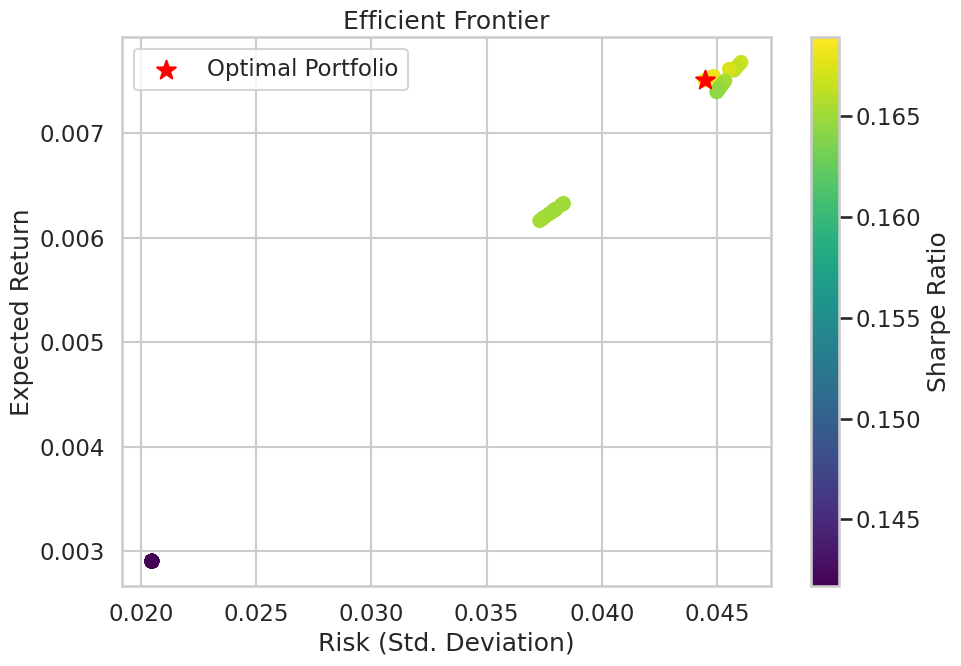

In [ ]:

def plot_efficient_frontier(df, optimal_point):

    # Plots the efficient frontier and highlights the optimal portfolio.

    plt.figure(figsize=(10, 7))
    plt.scatter(df["Std.Dev"], df["Exp.Return"], c=df["Sharpe"], cmap="viridis", marker="o")
    plt.colorbar(label="Sharpe Ratio")
    optimal = optimal_point
    plt.scatter(optimal["Std.Dev"], optimal["Exp.Return"], c="red", marker="*", s=200, label="Optimal Portfolio")
    plt.xlabel("Risk (Std. Deviation)")
    plt.ylabel("Expected Return")
    plt.title("Efficient Frontier")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Generate efficient frontier data
eff_df = make_port(mean_returns, cov_matrix, assets=assets, max_allocation=0.5, min_allocation=-0.5)
plot_efficient_frontier(eff_df, naive_opt)


## Evaluating Portfolio Performance

We assess the performance of the optimal portfolio by computing:
- **Cumulative Returns:** The compounded return over time.
- **Annualized Return:** The average return per year.
- **Annualized Risk:** The risk (standard deviation) scaled to an annual basis.
- **Sharpe Ratio:** The risk-adjusted return.

In [ ]:

naive_weights = naive_opt[assets].values
performance = port_performance(naive_opt, returns)
summary_stats = port_summary_updated(returns, naive_weights)

print("Naive Portfolio Performance Summary (Annualized):")
print(f"Annualized Return: {summary_stats[0]:.4f}")
print(f"Annualized Risk  : {summary_stats[1]:.4f}")
print(f"Sharpe Ratio     : {summary_stats[2]:.4f}")


Naive Portfolio Performance Summary (Annualized):
Annualized Return: 0.3905
Annualized Risk  : 0.3203
Sharpe Ratio     : 1.2191


## Interactive Visualization of Cumulative Returns

We use Plotly to create an interactive line chart that displays the cumulative returns of the optimal portfolio over time.

In [ ]:

import plotly.express as px

cum_returns = performance["tret"]
cum_returns_df = pd.DataFrame({
    "Date": returns.index,
    "Cumulative Return": cum_returns
})

fig = px.line(cum_returns_df, x="Date", y="Cumulative Return",
              title="Interactive Cumulative Returns - Naive Portfolio",
              labels={"Cumulative Return": "Cumulative Return"})
fig.update_layout(title_font_size=24, xaxis_title="Date", yaxis_title="Cumulative Return")
fig.show()
